In [1]:
import os,glob
import pandas as pd
import matplotlib.pyplot as plt
import pygmt
import pickle
import warnings  
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
warnings.filterwarnings("ignore")

In [7]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
path    = '/Volumes/home/Research/STEP/06_CIA_SWS_result/Station_SK(K)S_2010-2020average_v5.csv'

df = pd.read_csv(path)

In [9]:
def PygmtBegin(figmap, region, title):
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', f'nSeW+t"{title}"'])
    figmap.grdimage('@earth_relief_15s',region =region, cmap="/Volumes/home/Research/Python/eleva.cpt",monochrome=True, shading=True, transparency=60)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
#     figmap.plot(data=smooth_fault,pen='1p,brown')
    Volcano = '/Volumes/home/Research/DataBase/01_Armenia/02_Volcano_list.csv'
    dv = pd.read_csv(Volcano)
    dv_ = dv[dv['Plottype']==1]
    figmap.plot(x=dv_['lon'],y=dv_['lat'],style="kvolcano/0.4c", pen='0.1p,black', color="black")
    dv__ = dv[dv['Plottype']==3]
    figmap.plot(x=dv__['lon'],y=dv__['lat'],style="kvolcano/0.4c", pen='0.1p,', color="120")    
    figmap.plot(data='../individual_result/box.txt',color='white@30')
    figmap.plot([44.5, 47.5, 42.95, 44.5], color='white@40',style="r+s", pen="1p,white")
    legenddata=[[44.9, 44.0, 0, 5, 0.5*40],[45.8, 44.0, 0, 5, 1*40],[46.7, 44.0, 0, 5, 1.5*40]]
    figmap.plot(data=legenddata, style="J", color="black", pen="0.01p,black", no_clip=True)
    figmap.text(x=45.3,y=44.0,text='0.5s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=46.2,y=44.0,text='1s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=47.3,y=44.0,text='1.5s', font="12p,Times-Bold,black", no_clip=True)
    figmap.plot(x=44.85, y=43.75, style="c0.25c", color='white', pen="0.5p,40")
    figmap.text(x=45.05, y=43.75, text='Null',justify='LM', font="12p,Times-Bold,black")
    figmap.plot(x=44.85, y=43.55, style="c0.25c", color='180', pen="0.5p,40")
    figmap.text(x=45.05, y=43.55, text='No enough data',justify='LM', font="11p,Times-Bold,black")
    figmap.plot(x=46.45,y=43.75,style="kvolcano/0.4c", pen='0.1p,black', color="black") 
    figmap.text(x=46.6, y=43.75, text='Holocene',justify='LM', font="11p,Times-Bold,black")
    figmap.plot(x=46.45,y=43.55,style="kvolcano/0.4c", pen='0.1p,black', color="120") 
    figmap.text(x=46.6, y=43.55, text='Pleistocene',justify='LM', font="11p,Times-Bold,black")


In [4]:
# pygmt.makecpt(cmap='split',series=[-32,32,8],continuous=True, output='relative_ref46.cpt')
# pygmt.makecpt(cmap='panoply',series=[-32,32,8],continuous=True, output='relative_ref46_.cpt')

In [ ]:
regvals = [41, 47, 39.5, 44.2] ###Zoom in 
figmap = pygmt.Figure()
method = 'SC'

PygmtBegin(figmap, regvals, method)

for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    NetSta = f'{NET}.{STA}'
#     print(NetSta)
    if STA == 'CMCY' or STA == 'DGRL' :
        pass
    else:
        df_ = df[df['Station']==NetSta]
        if method == 'SC':
            color = 'red3'
            phi  = df_['SCphi'].values[0]
            dphi = df_['SCdphi'].values[0]
            dt   = df_['SCdt'].values[0]
            ddt  = df_['SCddt'].values[0]
        elif method == 'RC':
            color = 'dogerblue'
            phi  = df_['RCphi'].values[0]
            dphi = df_['RCdphi'].values[0]
            dt   = df_['RCdt'].values[0]
            ddt  = df_['RCddt'].values[0] 
            
        nonNull= df_['nonNull'].values[0]
        Null   = df_['Null'].values[0]
        numSKS = nonNull+Null
        if np.isnan(phi) == False:
            if nonNull <2: t = 50
            else: t = 0
            for std in np.arange(-dphi,dphi,2):
                std = phi+std
                error = [[st_lon, st_lat, std-90, 1.5, dt*40]]
                figmap.plot(data=error, style="J", color="170", transparency=t )
            data = [[st_lon, st_lat, phi-90, 6, dt*40]]

            figmap.plot(data=data, style="J", color=color, pen="0.1p,black", transparency=t )   
            figmap.plot(x=st_lon, y=st_lat,style="c0.4c",color='white' ,pen="0.8p,black")
            figmap.text(x=st_lon,y=st_lat,text=nonNull, font="6p,Times-Bold,black") 
        else: 
            if numSKS>3:
                figmap.plot(x=st_lon, y=st_lat, style="c0.25c", color='white', pen="0.5p,40")
            else:
                figmap.plot(x=st_lon, y=st_lat, style="c0.15c",color='grey59', pen="black")

        if STA == 'GUDG' or STA == 'TRLG' or STA == 'SEAG':
            figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="8p,Times-Bold,black",fill='white',transparency=30)
        else:
            figmap.text(x=st_lon,y=st_lat-0.1,text=STA, font="8p,Times-Bold,black",fill='white',transparency=30)

    # figmap.savefig(f'{SAVEpath}/01_RC_{YearRange}_v{ver}.pdf')
    # figmap.savefig(f'{SAVEpath}/01_RC_{YearRange}_v{ver}.png',dpi=200)         
figmap.show()

In [13]:
STApath

'/Volumes/home/Research/STEP/01_Split/XG_CMCY.pkl'

VAND 20200805_120536
VAND 20190731_150233
VAND 20160729_211826
VAND 20180211_231415
ZARN 20180211_231415
GUDG 20131123_074832
TBLG 20130523_210746
KIV 20140326_032936
KIV 20181223_230843
KIV 20170926_042000
GNI 20131123_074832
GNI 20200613_210830
GNI 20130514_003226


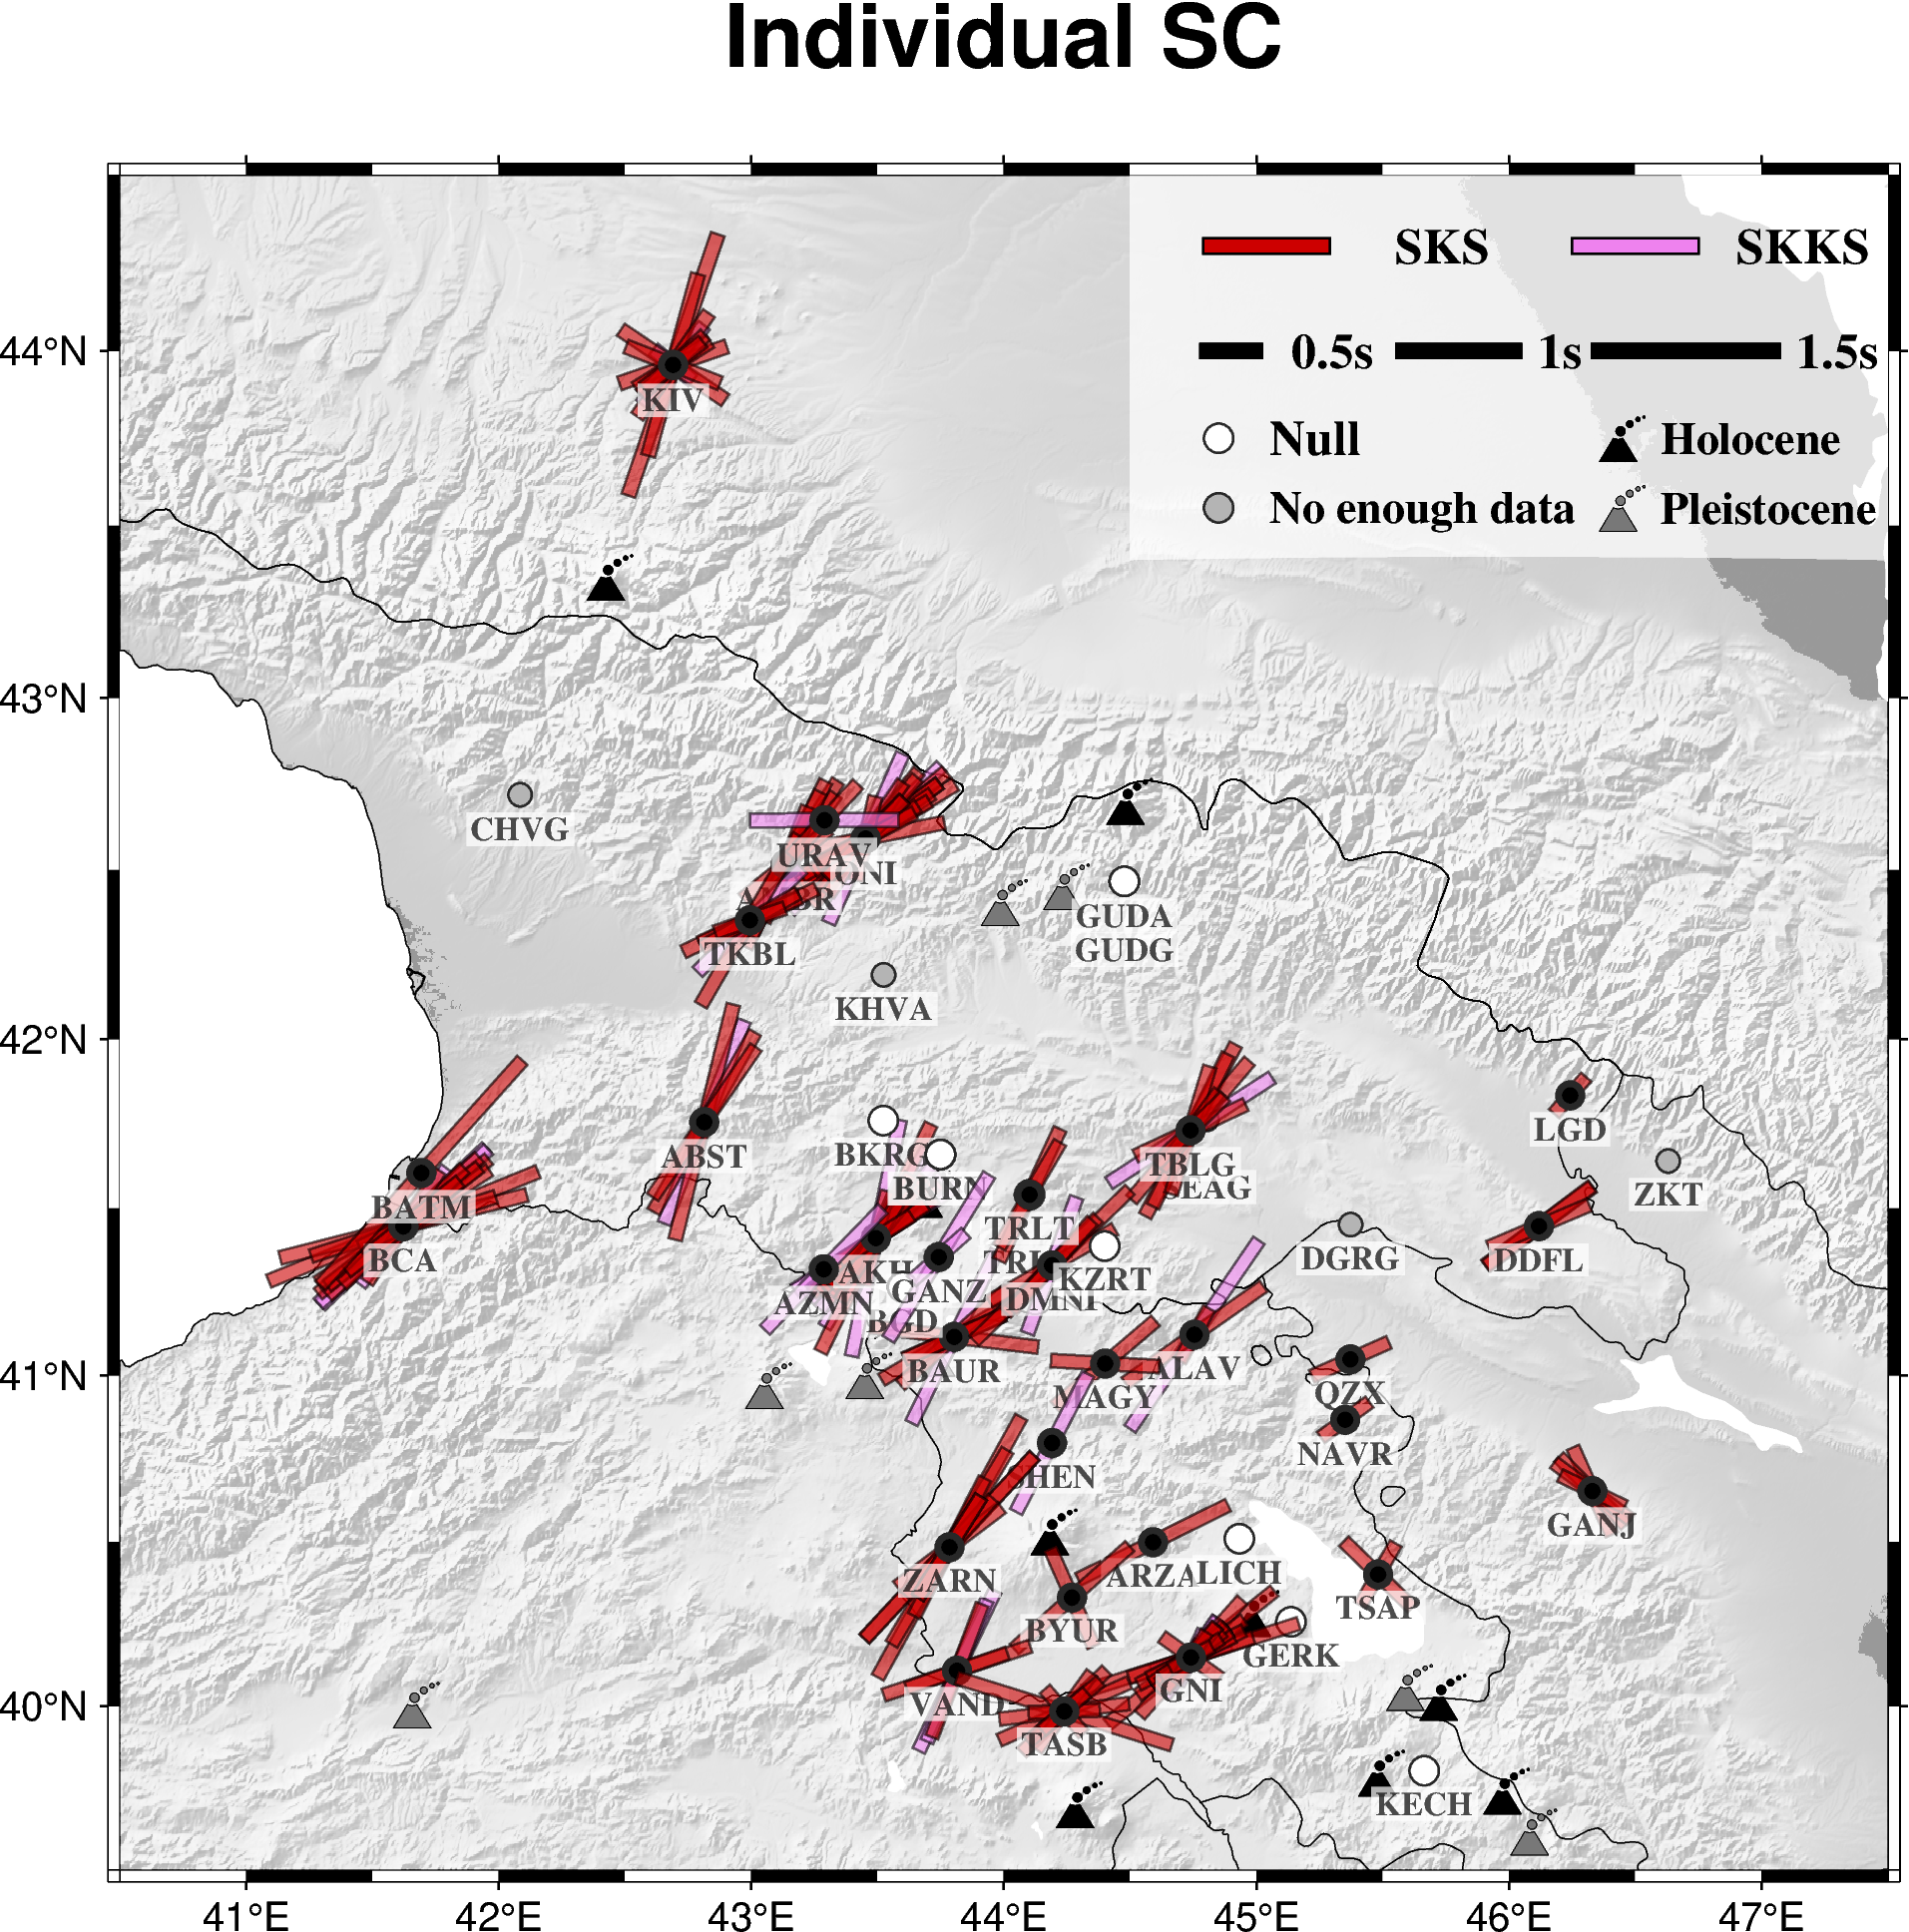

In [98]:
method = 'SC'
figmap = pygmt.Figure()
region = [40.5, 47.5, 39.5, 44.5]
title  = f'Individual {method}'
PygmtBegin(figmap,region,title)
if method == 'SC':
    SKScolor='red3'; SKKScolor='violet'
elif method == 'RC':
    SKScolor='dodgerblue'; SKKScolor='lightblue'
SKSdata=[[45.04, 44.3, 0, 5, 1*40]]
figmap.plot(data=SKSdata, style="J", color=SKScolor, pen="0.5p,black", no_clip=True)
figmap.text(x=45.55, y=44.3, text='SKS',justify='LM', font="12p,Times-Bold,black")
SKKSdata=[[46.5, 44.3, 0, 5, 1*40]]
figmap.plot(data=SKKSdata, style="J", color=SKKScolor, pen="0.5p,black", no_clip=True)
figmap.text(x=46.9, y=44.3, text='SKKS',justify='LM', font="12p,Times-Bold,black")


# figmap.colorbar(cmap='relative_ref46.cpt',position="x9.5c/14.5c+w5c/0.3c+h",frame=["xa8f4", "x+lRelative to 46\\260"])
for pkl in sorted(glob.glob(f'{PKLpath}/*.pkl')):
    STApkl = pickle.load(open(pkl, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    sta = values['station'];net = values['network']
    if sta == 'CMCY' or sta == 'DGRL' :
        pass
    else:
        stlat = values['latitude']; stlon = values['longitude']
        for resultpath in sorted(glob.glob(f'{path}/2010-2020_*_classify/{net}.{sta}*result.csv')):
            df = pd.read_csv(resultpath)
            dff = df[df['Null']==False][df['Quality']!='Poor'][df['Pick']==True]
            dff = dff.sort_values(by=['SCdt'],ascending=False)
            for i in range(len(dff)):
                event = dff['Event'].values[i]
                evlat = dff['Ev_lat'].values[i]
                evlon = dff['Ev_lon'].values[i]
                evdep = dff['Depth'].values[i]
                phase = dff['Phase'].values[i]
                if sta in dr['station'].to_list() and event in dr['time'].to_list():
                        print(f'{sta} {event}')
                else:
                    phi = dff['SCPhi'].values[i]
                    dt  = dff['SCdt'].values[i]
                    data = [[stlon, stlat, phi-90, 4.5, dt*40]]
                    
                    if phase == 'SKS':
                        cc=SKScolor
                    elif phase == 'SKKS':
                        cc=SKKScolor
                    figmap.plot(data=data, style="J", color=cc, pen="0.5p,black",transparency=40, no_clip=True)  

        if sta in NULLsta:
            figmap.plot(x=stlon, y=stlat, style="c0.25c", color='white', pen="0.5p,40")
        elif sta in Nodatasta:
            figmap.plot(x=stlon, y=stlat, style="c0.2c", color='180', pen="0.5p,40")
        else:
            figmap.plot(x=stlon, y=stlat, style="c0.2c", color='black', pen="1.5p,40")
        if sta == 'GUDG' or sta == 'TRLG' or sta == 'SEAG':
            figmap.text(x=stlon,y=stlat-0.2,text=sta, font="8p,Times-Bold,black",fill='white',transparency=30)
        else:
            figmap.text(x=stlon,y=stlat-0.1,text=sta, font="8p,Times-Bold,black",fill='white',transparency=30)
figmap.show()    
# figmap.savefig(f'Individual_result_{method}.png',dpi=200)
# figmap.savefig(f'Individual_result_{method}.pdf',dpi=200)

In [97]:
for resultpath in sorted(glob.glob(f'{path}/2010-2020_*_classify/*BATM*result.csv')):
    df = pd.read_csv(resultpath)
    dff = df[df['Null']==False][df['Quality']!='Poor'][df['Pick']==True]
    print(dff)

Empty DataFrame
Columns: [Event, Ev_lat, Ev_lon, Depth, Mag, Phase, SCPhi, SCPhi_std, SCdt, SCdt_std, RCPhi, RCPhi_std, RCdt, RCdt_std, SNRQ, SNRT, Null, Quality, CpH, Pick, coeff]
Index: []

[0 rows x 21 columns]
              Event   Ev_lat    Ev_lon  Depth  Mag Phase  SCPhi  SCPhi_std  \
12  20140412_201438 -11.2581  162.1387   15.3  7.6   SKS   42.0        8.5   

    SCdt  SCdt_std  ...  RCPhi_std  RCdt  RCdt_std   SNRQ  SNRT   Null  \
12   2.5       0.5  ...      44.75   2.2      0.98  15.31   3.0  False   

    Quality   CpH  Pick  coeff  
12     Fair  0.33  True  -0.43  

[1 rows x 21 columns]
